<a href="https://colab.research.google.com/github/MarioAvolio/AI-Project/blob/main/Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt # plotting
import numpy as np

In [3]:
!pip uninstall transformers -y # https://github.com/huggingface/transformers/issues/22816
!pip install transformers==4.28.0
!pip install accelerate -U
from transformers import Trainer, TrainingArguments

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 7.3 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
PATH_PROJ = "/content/drive/MyDrive/AI-proj/"

In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt # plotting
import numpy as np

In [9]:
!pip uninstall transformers -y # https://github.com/huggingface/transformers/issues/22816
!pip install transformers==4.28.0
!pip install accelerate -U
from transformers import Trainer, TrainingArguments

Found existing installation: transformers 4.28.0
Uninstalling transformers-4.28.0:
  Successfully uninstalled transformers-4.28.0
  Using cached transformers-4.28.0-py3-none-any.whl (7.0 MB)


In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
PATH_PROJ = "/content/drive/MyDrive/data-proj/"
# if not os.path.exists(PATH_PROJ):
#   PATH_PROJ = "/content/drive/MyDrive/shared/data-proj/"

PATH_DATASET = PATH_PROJ+"food.csv"
PATH_DATASET_FIRST_PREPROCESSING = PATH_PROJ+"first_preprocessing.csv"
NUM_CLASSES=3
score_to_sentiment = {
    0: "NEGATIVE",
    1: "NEUTRAL",
    2: "POSITIVE"
}

In [12]:
!pip install datasets # https://github.com/huggingface/datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.9 MB/s eta 0:00:00


In [13]:
from datasets import get_dataset_config_names
domains = get_dataset_config_names("subjqa")
domains # ['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

Building a QA system for the Movies domain.

In [16]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", "movies")

  0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
# Like other question answering datasets on the Hub, SubjQA stores the answers to
# each question as a nested dictionary. For example, if we inspect one of the rows in the
# answers column:
print(subjqa["train"]["answers"][10])


{'text': ['It is simply astounding', 'The movie is really shocking and appalling'], 'answer_start': [164, 1518], 'answer_subj_level': [1, 1], 'ans_subj_score': [1.0, 1.0], 'is_ans_subjective': [True, True]}


 To explore the dataset more easily, we’ll flatten these nested columns with the flatten() method and convert each split to a Pandas
DataFrame as follows

In [20]:
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1369
Number of questions in test: 291
Number of questions in validation: 261


Let’s focus on these columns and take a look at a few of the training examples. We can
use the sample() method to select a random sample:

In [22]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
263,630428845X,How is the story?,[],[],This has got to be one of the most boring and ...
313,630575067X,How is character?,[the digital characters],[1071],"Like most Star Wars fans, I literally counted ..."


From these examples we can make a few observations. First, the questions are not
grammatically correct, which is quite common in the FAQ sections of ecommerce
websites. Second, an empty answers.text entry denotes “unanswerable” questions
whose answer cannot be found in the review. Finally, we can use the start index and
length of the answer span to slice out the span of text in the review that corresponds
to the answer:

In [31]:
start_idx = sample_df["answers.answer_start"].iloc[1][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[1][0])
sample_df["context"].iloc[1][start_idx:end_idx]

'the digital characters'

Next, let’s get a feel for what types of questions are in the training set by counting the
questions that begin with a few common starting words:

In [38]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why", "When","What","Who","Whom","Whose","Which"]


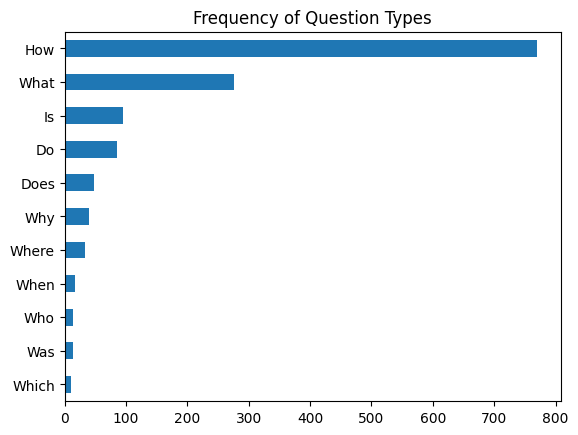

In [42]:

for q in question_types:
  try:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
  except:
    continue
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

We can see that questions beginning with “How”, “What”, and “Is” are the most com‐
mon ones, so let’s have a look at some examples:

In [43]:
for question_type in ["How", "What", "Is"]:
  for question in (
    dfs["train"][dfs["train"].question.str.startswith(question_type)]
    .sample(n=3, random_state=42)['question']):
    print(question)

How is the story line?
How is the music?
How can I read the set story at this hotel?
What is the price of the dvd?
What is the really things?
What is the quality of the paint?
Is the main character a good actor?
Is the color better?
Is the actor a funny acting?
